In [1]:
# --- IMPORTS ---


import pandas as pd
import requests
from io import StringIO
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from sentence_transformers import SentenceTransformer, util
import torch
import time
import math


# Show full string contents in DataFrames - need this for checking addresses later
pd.set_option('display.max_colwidth', None)

#printing the current time so we can be certain a thing has run now and not just earlier
print(f"Done! Current time: {time.strftime('%Y-%m-%d %H:%M:%S')}")


Done! Current time: 2025-09-28 19:48:09


In [2]:
# --- PLANNING APPLICATION DATA ---

# retrieve the data
url = "https://opendata.camden.gov.uk/api/views/2eiu-s2cw/rows.csv?accessType=DOWNLOAD"


headers = {"User-Agent": "Mozilla/5.0"}
response = requests.get(url, headers=headers)

if response.status_code == 200:
    data = StringIO(response.text)
    df = pd.read_csv(data)
    print(df.head())

     # Calculate maximum ward name length - we've got some dodgy ones that need cleaning
    max_ward_length = df['Ward'].astype(str).str.len().max()
    print(f"Longest ward name length: {max_ward_length}")
    
else:
    print("Failed to download, status code:", response.status_code)



print(f"Current time: {time.strftime('%Y-%m-%d %H:%M:%S')}")

    

       ID Application Number  \
0  244655        2010/4360/T   
1  215754        2010/1218/P   
2  307630        2012/2307/P   
3  310796        2012/2672/L   
4  227582        2010/2468/P   

                                                           Development Address  \
0                                               47 Rosslyn Hill London NW3 5UH   
1                                                 2 Malden Road London NW5 3HR   
2                              Craven House  119-123 Kingsway London  WC2B 6PA   
3  The Granary Building  Kings Cross Development Zone L York Way London N1 0AU   
4                      23-30 Kings Mews & 43-45 Grays Inn Road London WC1N 2JB   

                                                                                                                                                                                                                                                                                                                          

In [3]:
# --- VIEW PLANNING APPLICATION DATA ---

# See column names
print(df.columns)

# Quick info to check types and nulls
df.info()

print(f"Current time: {time.strftime('%Y-%m-%d %H:%M:%S')}")


Index(['ID', 'Application Number', 'Development Address',
       'Development Description', 'Decision Type', 'Valid From Date',
       'Registered Date', 'Registered In Last 7 Working Days',
       'Registered In Last 28 Working Days', 'Earliest Decision Date',
       'Decision Date', 'Decision Level', 'System Status',
       'System Status Change Date', 'Applicant Name', 'Ward',
       'Conservation Areas', 'Neighbourhood Areas', 'Case Officer',
       'Case Officer Team', 'Responsibility Type', 'Comment',
       'Full Application', 'Application Type', 'Easting', 'Northing',
       'Longitude', 'Latitude', 'Spatial Accuracy', 'Last Uploaded',
       'Location', 'Socrata ID', 'Organisation URI'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77966 entries, 0 to 77965
Data columns (total 33 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   ID                          

In [4]:
# --- CLEAN PLANNING APPLICATION DATA ---

# Rename columns to snake_case for convenience
df.rename(columns={
    'Development Description': 'development_description',
    'Decision Type': 'decision',
    'Decision Date': 'decision_date',
    'Ward': 'ward',
    'Development Address': 'development_address'
    
}, inplace=True)

# Trim anything from the first "(" onward in ward names
df['ward'] = df['ward'].str.replace(r"\s*\(.*", "", regex=True).str.strip()


# Keep only relevant columns + Development Address for postcode extraction
# in first iteration ward names were iffy so will use postcode + census postcode data to fix
df = df[['development_description', 'decision', 'decision_date', 'ward', 'development_address']]

# Drop rows with missing essential info -- could we keep in rows without decision or decision date???
df = df.dropna(subset=['development_description', 'decision', 'decision_date', 'ward'])

# Regex for UK postcodes - refined manually using no_postcode_df below
postcode_regex = r'([A-Z]{1,2}\d[A-Z\d]?\s*\d[A-Z]{2})'

# Extract postcode
df['postcode_temp'] = df['development_address'].str.extract(postcode_regex, expand=False)

# Standardize: remove spaces and uppercase
df['postcode_1'] = df['postcode_temp'].str.replace(" ", "", regex=False).str.upper()


# Check how many matched now
matched = df['postcode_1'].notna().sum()
total = len(df)
not_matched = total - matched
print(f"Rows with matched postcode: {matched}")
print(f"Rows without a matched postcode: {not_matched}")

# Preview unmatched addresses - used to fine tune regex
no_postcode_df = df[df['postcode_1'].isna()]
no_postcode_df[['development_address']]

print(f"Current time: {time.strftime('%Y-%m-%d %H:%M:%S')}")



Rows with matched postcode: 74527
Rows without a matched postcode: 1934
Current time: 2025-09-28 19:48:22


In [5]:
# --- CHECK WHAT OUR DATA LOOKS LIKE AGAIN ---

# Count number of entries per ward
ward_counts = df['ward'].value_counts().sort_values(ascending=False)

num_unique_wards = df['ward'].nunique()
print(f"Number of unique wards: {num_unique_wards}")

ward_counts_df = ward_counts.reset_index()
ward_counts_df.columns = ['ward', 'Application Count']
print(ward_counts_df)

print(f"Current time: {time.strftime('%Y-%m-%d %H:%M:%S')}")


Number of unique wards: 101
                                       ward  Application Count
0                            Hampstead Town               7844
1                   Holborn & Covent Garden               6745
2                                Bloomsbury               6202
3                       Frognal & Fitzjohns               6111
4                                  Highgate               5385
..                                      ...                ...
96   Holborn and Covent Garden;Regents Park                  1
97                   Belsize;West Hampstead                  1
98                  Frognal;South Hampstead                  1
99            West Hampstead;West Hampstead                  1
100                Haverstock;Primrose Hill                  1

[101 rows x 2 columns]
Current time: 2025-09-28 19:48:22


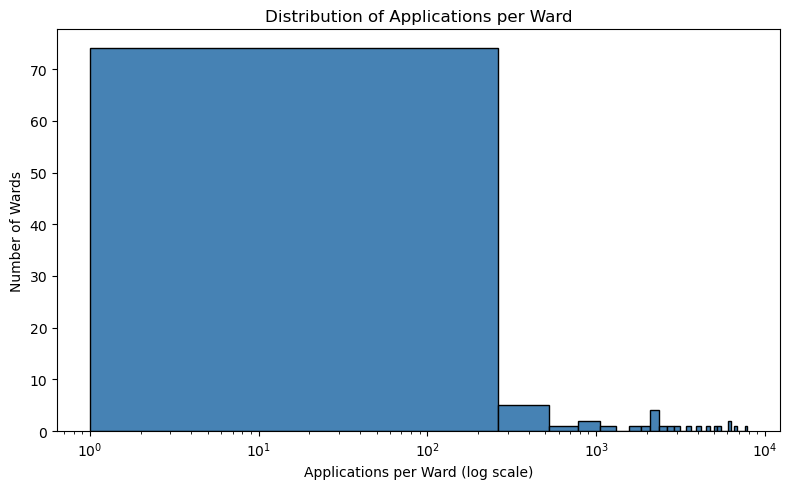

Current time: 2025-09-28 19:48:22


In [6]:
# --- VISUALISING OUTLIERS V1 ---

''' want a way to visualise outliers, specifically wards with very few applications
likely caused by having the names entered weirdly
obviously the log linear chart doesn't work well
'''
plt.figure(figsize=(8,5))
plt.hist(
    ward_counts_df['Application Count'],
    bins=30,
    color='steelblue',
    edgecolor='black'
)
plt.xscale('log')   # log scale for applications
plt.xlabel("Applications per Ward (log scale)")
plt.ylabel("Number of Wards")
plt.title("Distribution of Applications per Ward")
plt.tight_layout()
plt.show()

print(f"Current time: {time.strftime('%Y-%m-%d %H:%M:%S')}")


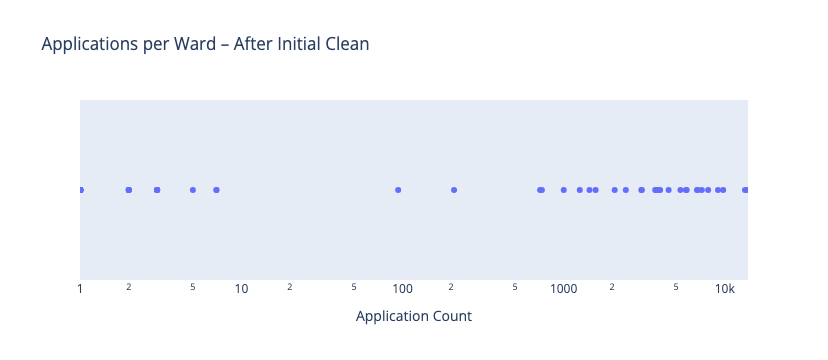

Chart rendered at: 2025-09-28 20:13:59


In [16]:
# --- VISUALISING OUTLIERS V2 ---

'''normally I would put dependent variable on y but screens are landscape'''

def plot_ward_strip(df, title):
    fig = px.strip(
        df, x="Application Count", y=[0]*len(df),
        hover_name="Ward", title=title
    )
    fig.update_xaxes(type="log")
    fig.update_yaxes(visible=False)
    fig.show()
    print(f"Chart rendered at: {time.strftime('%Y-%m-%d %H:%M:%S')}")

plot_ward_strip(ward_counts_df, "Applications per Ward – After Initial Clean")


In [17]:
# --- CLEANING WARD NAMES USING CENSUS POSTCODE DATA ---

# Way too slow to pull full 1.8m data set so use Socrata CSV endpoint with query parameters 
url = ( "https://opendata.camden.gov.uk/resource/tr8t-gqz7.csv" "?$select=postcode_1,ward_name" "&$where=local_authority_code='E09000007'" )

# Read data into pandas
camden_postcodes = pd.read_csv(url)

# Deduplicate to ensure unique postcode-ward pairs
camden_postcodes = camden_postcodes.drop_duplicates().reset_index(drop=True)

print(f"Rows retrieved: {len(camden_postcodes)}")

print(camden_postcodes.head())

 # Calculate maximum ward name length
max_ward_length_census = camden_postcodes['ward_name'].astype(str).str.len().max()
print(f"Longest ward name length: {max_ward_length_census}")

print(f"Current time: {time.strftime('%Y-%m-%d %H:%M:%S')}")


Rows retrieved: 1000
  postcode_1           ward_name
0    W1T 4AG          Bloomsbury
1    NW3 1TN      Hampstead Town
2    NW5 3DS  Kentish Town South
3    NW6 1XZ      West Hampstead
4    NW3 1NY      Hampstead Town
Longest ward name length: 24
Current time: 2025-09-28 20:14:05


In [18]:
# --- REPLACE PLANNING APPLICATION WARD NAMES WITH CENSUS WARD NAMES BY MATCHING ON POSTCODE ---


# Count rows where original ward length exceeds the max ward length
overlong_before = df['ward'].astype(str).str.len().gt(max_ward_length).sum()
print(f"Before cleaning – rows with ward length > max_ward_length: {overlong_before}")


'''Turns out the census data doesn't have every postcode. 
Long-term solution would be to use a more complete data source
Short-term solution will be to assume:
    postcodes that match up to but excluding last character
    will be in the same ward.
This will be true in reality almost always.
'''

# Remove last character before matching
df['postcode_trim'] = df['postcode_1'].str[:-1]

camden_postcodes['postcode_trim'] = (
    camden_postcodes['postcode_1']
      .str.replace(" ", "", regex=False)
      .str.upper()
      .str[:-1]
)


# Merge on trimmed postcodes 
df_merged = df.merge(
    camden_postcodes[['postcode_trim', 'ward_name']],
    on='postcode_trim',
    how='left',
    suffixes=('', '_census')
)

#  Replace original ward with census ward wherever available 
df_merged['ward_final'] = df_merged['ward_name'].fillna(df_merged['ward'])


# Flag where a census ward was available 
df_merged['census_matched'] = df_merged['ward_final'] != df_merged['ward']

# Count rows where postcode match gave a census ward
census_matches = df_merged['ward_final'].notna() & df_merged['postcode_trim'].notna()
num_census_wards = census_matches.sum()
print(f"Number of planning applications where a Camden ward was pulled from census: {num_census_wards}")

# Count replacements 
replaced_count = df_merged['census_matched'].sum()
not_replaced_count = len(df_merged) - replaced_count
print(f"Ward replaced (using census data): {replaced_count}")
print(f"Ward not replaced (kept original or missing): {not_replaced_count}")

print(f"Done: {time.strftime('%Y-%m-%d %H:%M:%S')}")

Before cleaning – rows with ward length > max_ward_length: 0
Number of planning applications where a Camden ward was pulled from census: 127202
Ward replaced (using census data): 50810
Ward not replaced (kept original or missing): 78326
Done: 2025-09-28 20:14:07


In [19]:
# --- CLEAN DATA AGAIN ---

'''
Probably better to do it for all wards, seems like others also have apostrophe problem

# Normalize "kings cross" to "king's cross - found this from a viz way later"
df_merged['ward_final'] = df_merged['ward_final'].str.replace(r'^kings cross$', "king's cross", case=False)
'''
# --- Normalise names re. apostrophes ---

# Get all unique ward names
unique_wards = df_merged['ward_final'].dropna().unique()

# Find pairs where one has an apostrophe and the other doesn't
# We'll map the non-apostrophe version to the apostrophe version - not sure this is always right!!!
apostrophe_map = {}
for ward in unique_wards:
    if "'" in ward:
        no_apostrophe = ward.replace("'", "")
        apostrophe_map[no_apostrophe.lower()] = ward  # lowercase for matching

# Apply mapping to all ward_final entries
def standardize_apostrophe(ward):
    if pd.isna(ward):
        return ward
    
    # Split multiple wards by semicolon
    parts = [p.strip() for p in ward.split(';')]
    
    # Replace any part without apostrophe if mapped
    parts = [apostrophe_map.get(p.lower(), p) for p in parts]
    
    # Collapse identical parts if all the same
    if len(set(parts)) == 1:
        return parts[0]
    else:
        return '; '.join(parts)

    # Convert to Camel Case - still having problems around apostrophes!!!
    def camel_case(text):
        return ' '.join([w.capitalize() if w else '' for w in text.split()])
    
    return camel_case(single)

df_merged['ward_final'] = df_merged['ward_final'].apply(standardize_apostrophe)

print(f"Done: {time.strftime('%Y-%m-%d %H:%M:%S')}")

Done: 2025-09-28 20:14:21


In [20]:
# --- MORE CLEANING ---

# Normalize multiple identical ward names separated by semicolons - also spotted the need for this much later 
def simplify_semicolon_wards(ward):
    if pd.isna(ward):
        return ward
    parts = [p.strip().lower() for p in ward.split(';')]
    # If all parts are identical, just keep the first
    if len(set(parts)) == 1:
        return parts[0].title()  # capitalize properly
    else:
        return ward  # leave as-is if they differ

df_merged['ward_final'] = df_merged['ward_final'].apply(simplify_semicolon_wards)

ward_counts_df = (
    df_merged.groupby('ward_final', dropna=False)
             .size()
             .reset_index(name='Application Count')
             .sort_values('Application Count', ascending=False)
)

print(f"Done: {time.strftime('%Y-%m-%d %H:%M:%S')}")

Done: 2025-09-28 20:14:46


In [21]:
# --- CHECK DATA AGAIN ---

print(df_merged.head())

print(ward_counts_df.head()) 

# Calculate maximum ward name length

max_ward_length = df_merged['ward_final'].astype(str).str.len().max()
print(f"Longest ward name length: {max_ward_length}")

# Count rows where final ward length exceeds the max ward length
overlong_after = df['ward'].astype(str).str.len().gt(max_ward_length_census).sum()
print(f"After cleaning – rows with ward length > max_ward_length: {overlong_after}")

print(f"Aggregated ward counts at: {time.strftime('%Y-%m-%d %H:%M:%S')}")

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            development_description  \
0                                                                                                                                                                                                                                

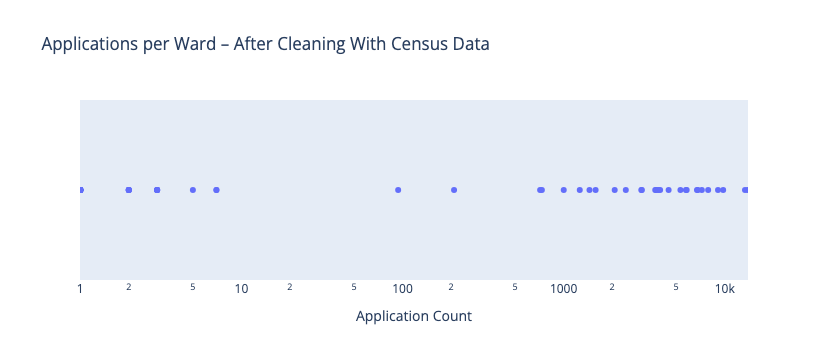

Chart rendered at: 2025-09-28 20:15:04


In [22]:
# --- VISUALISING CLEANED DATA ---

ward_counts_df.rename(columns={"ward_final": "Ward"}, inplace=True)
plot_ward_strip(ward_counts_df, "Applications per Ward – After Cleaning With Census Data")


In [23]:
# --- ASSESSING GREEN CREDENTIALS: STARTING MODEL ---


'''I don't want to be limited by a manual set of words so I'm trying with sentencetransformer
- never used this before'''

start_time = time.time()

# Load model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Define multiple "green/sustainable" concepts
green_concepts = [
    "green development",
    "sustainable building",
    "eco-friendly design",
    "low-carbon construction",
    "energy efficient",
    "environmentally friendly"
]

# Encode all concept phrases
concept_embeddings = model.encode(green_concepts, convert_to_tensor=True)

print(f"Model loaded and concepts encoded! Time elapsed: {time.time() - start_time:.1f} sec")

print(f"Current time: {time.strftime('%Y-%m-%d %H:%M:%S')}")


Model loaded and concepts encoded! Time elapsed: 2.4 sec
Current time: 2025-09-28 20:15:23


In [24]:
# --- SET UP AND RUN MODEL ---

''' tried originally doing entire descriptions in one go
results were rubbish - only one green application
Have attempted chunking. Lots of play here to try to get things fast enough.
Seems like encoding all chunks at once makes a big difference.
The whole project depends on the concept encoding - huge room for improvement here.
'''

start_time = time.time()

# --- Settings ---
chunk_size = 250  # words per chunk
batch_size = 300  # descriptions per batch
threshold = 0.30   # similarity threshold for "green"
descriptions = df_merged['development_description'].tolist()
total_desc = len(descriptions)

# --- Base concept phrases ---
base_concepts = [
    "environmentally-friendly", "green development", "sustainable development",
    "eco-friendly", "low carbon", "carbon footprint", "renewable energy", "recycle"
]

# --- Load model ---
model = SentenceTransformer('all-MiniLM-L6-v2')

# Expand concepts automatically
# Candidate terms for possible expansion
candidate_terms = [
    "energy efficiency", "insulation", "LED lighting", "passive design",
    "water recycling", "rainwater harvesting", "zero waste",
    "green roof", "urban greening", "pollinator habitat",
    "flood resilience", "stormwater management", "low carbon transport",
    "biodiversity", "carbon reduction", "climate adaptation"
]

# Encode base concepts and candidates
base_embeddings = model.encode(base_concepts, convert_to_tensor=False)
candidate_embeddings = model.encode(candidate_terms, convert_to_tensor=False)

# Compute similarity and keep only candidates that are semantically close
cos_scores = util.cos_sim(torch.tensor(candidate_embeddings), torch.tensor(base_embeddings))
expanded_terms = [term for term, score in zip(candidate_terms, cos_scores.max(dim=1).values.tolist()) if score > 0.6]

# Final concept list = base + expanded
concepts = base_concepts + expanded_terms
print(f"Using concepts for matching: {concepts}")

# Precompute concept embeddings once
concept_embeddings = model.encode(concepts, convert_to_tensor=False)  # NumPy arrays for CPU

# Function to chunk a description
def chunk_text(text, n_words=chunk_size):
    words = text.split()
    return [" ".join(words[i:i+n_words]) for i in range(0, len(words), n_words)]

# Main loop over description batches
is_green_list = []

for i in range(0, total_desc, batch_size):
    batch_desc = descriptions[i:i+batch_size]
    
    # Chunk all descriptions in batch
    batch_chunks = []
    mapping = []
    for idx, desc in enumerate(batch_desc):
        chunks = chunk_text(desc)
        batch_chunks.extend(chunks)
        mapping.extend([idx]*len(chunks))
    
    # Encode all chunks at once
    chunk_embeddings = model.encode(batch_chunks, convert_to_tensor=False)
    
    # Compute cosine similarity to concepts
    cos_scores = util.cos_sim(torch.tensor(chunk_embeddings), torch.tensor(concept_embeddings))
    
    # Max similarity per chunk across concepts
    max_per_chunk = torch.max(cos_scores, dim=1).values
    
    # Max similarity per description
    desc_scores = [0]*len(batch_desc)
    for score, desc_idx in zip(max_per_chunk.tolist(), mapping):
        desc_scores[desc_idx] = max(desc_scores[desc_idx], score)
    
    # Apply threshold
    is_green_list.extend([score > threshold for score in desc_scores])
    
    print(f"Processed batch {i//batch_size + 1}/{math.ceil(total_desc/batch_size)} "
          f"- elapsed {time.time() - start_time:.1f}s")

# Assign back to dataframe
df_merged['is_green'] = is_green_list

print(f"Green/sustainable flagging complete! Total time: {time.time() - start_time:.1f} sec")
print(f"Current time: {time.strftime('%Y-%m-%d %H:%M:%S')}")
df_merged[['development_description', 'is_green']].head(10)


Using concepts for matching: ['environmentally-friendly', 'green development', 'sustainable development', 'eco-friendly', 'low carbon', 'carbon footprint', 'renewable energy', 'recycle', 'energy efficiency', 'water recycling', 'urban greening', 'low carbon transport', 'carbon reduction']
Processed batch 1/431 - elapsed 2.6s
Processed batch 2/431 - elapsed 3.2s
Processed batch 3/431 - elapsed 3.7s
Processed batch 4/431 - elapsed 4.3s
Processed batch 5/431 - elapsed 4.8s
Processed batch 6/431 - elapsed 5.4s
Processed batch 7/431 - elapsed 5.9s
Processed batch 8/431 - elapsed 6.4s
Processed batch 9/431 - elapsed 6.9s
Processed batch 10/431 - elapsed 7.3s
Processed batch 11/431 - elapsed 7.7s
Processed batch 12/431 - elapsed 8.2s
Processed batch 13/431 - elapsed 8.5s
Processed batch 14/431 - elapsed 9.1s
Processed batch 15/431 - elapsed 9.7s
Processed batch 16/431 - elapsed 10.2s
Processed batch 17/431 - elapsed 10.6s
Processed batch 18/431 - elapsed 11.1s
Processed batch 19/431 - elapsed 

,development_description,is_green
0,"REAR GARDEN: 1 x Ash - Remove branches overhanging 1 Thurlow Road, thin crown and reduce by 30%",False
1,"Change of use of ground level shop (Class A1) and associated basement storage and staff room to a live/work unit (Sui Generis), including alterations to both front elevations to include new windows and a door plus an enlarged lightwell with railings on the Prince of Wales Rd frontage",False
2,"Variation of condition 6 of planning permission dated 27/02/12 (ref: 2011/5090/P) for change of use of part of existing retail unit (Class A1) at basement and ground floor to restaurant use (Class A3), to vary the opening hours from 12:00hrs to 23:00hrs Monday to Saturday and 12:00hrs to 22:00hrs Sundays and Bank Holidays to 10:00hrs to 00:00hrs Monday to Saturday and 10:00hrs to 23:00hrs on Sundays and Bank Holidays.",False
3,Details of lighting fixtures and fittings required by condition 21a (xxi) of listed building consent 2007/5230/L dated 08/04/2008 for alterations to Granary Building.,False
4,"Details of a programme of archaeological investigation, pursuant to condition 5 of planning permission reference 2009/0710/P granted on 13/05/2009 for the redevelopment of the site following the demolition of the existing 2 and 3 storey storage buildings at 23-30 Kings Mews including the erection of a new part 3, part 4 storey building to accommodate 18 private residential flats, and erection of rear extension at first to third floor levels and mansard roof extension at fourth floor level at 43-45 Gray's Inn Road and provision of a new shopfront associated with the retained retail use at ground and basement floor levels, and change of use of the upper floors from part offices and part residential to a wholly residential use to accommodate 7 affordable flats.",False
5,Installation of disabled access ramp in front of the communal entrance to Flats 7 to 13 (Class C3).,False
6,Installation of disabled access ramp in front of the communal entrance to Flats 7 to 13 (Class C3).,False
7,The installation of a new shopfront to ground floor shop and conversion of two upper floors to provide a maisonette.,False
8,"Erection of a two-storey side extension (fronting onto Lamble Street), installation of railings on front boundary wall (Julia Street) and associated alterations to single-family dwellinghouse (Class C3)",False
9,"Samples required by condition 2 of Planning Permission Ref 2008/5547/P dated 31/03/2009 for amendments to planning permission 2007/4108/P, dated 09/11/2007, for refurbishment of building including erection of new roof extension and rear extension to provide additional office space (Use Class B1), works to office core and lightwell and reversion of entire third floor to office use from part office/part D1 education use. Revisions include alterations to the rear (Gate Street) façade, roof level plant and front (Kingsway) elevation entrance.",False


In [25]:
# --- SUMMARISE DATA BY WARD ---
ward_summary = (
    df_merged.groupby('ward_final', dropna=False)
             .agg(
                 total_count=('is_green', 'size'),
                 green_count=('is_green', 'sum')
             )
             .reset_index()
)
ward_summary['pct_green'] = ward_summary['green_count'] / ward_summary['total_count'] * 100

print(f"Current time: {time.strftime('%Y-%m-%d %H:%M:%S')}")

Current time: 2025-09-28 20:18:58


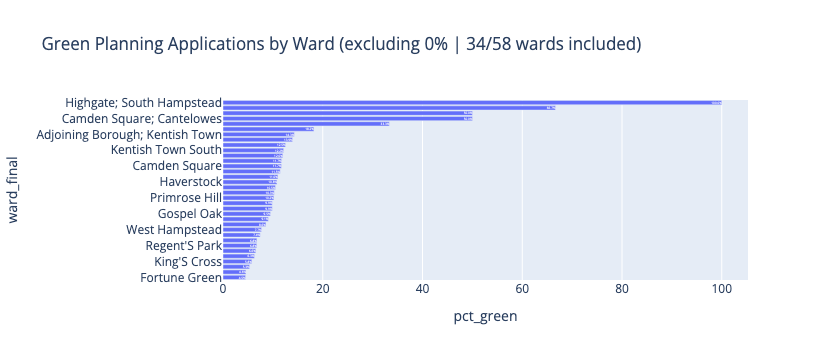

Current time: 2025-09-28 20:19:02


In [26]:
# --- VISUALISING GREEN APPLICATIONS BY WARD ---


# Filter out wards with 0% green
ward_summary_filtered = ward_summary[ward_summary['pct_green'] > 0].copy()

# Sort by percentage descending
ward_summary_filtered = ward_summary_filtered.sort_values('pct_green', ascending=False)

# Count included and total wards
num_included = len(ward_summary_filtered)
num_total = len(ward_summary)

# Build title
chart_title = f"Green Planning Applications by Ward (excluding 0% | {num_included}/{num_total} wards included)"

# Build hover text using hovertemplate
hover_template = (
    "%{y}<br>" +                 # ward name
    "%{x:.1f}%<br>" +            # percentage
    "%{customdata[0]}/%{customdata[1]}" +  # green_count / total_count
    "<extra></extra>"             # remove trace info
)

fig = px.bar(
    ward_summary_filtered,
    x='pct_green',
    y='ward_final',
    orientation='h',
    title=chart_title,
    custom_data=['green_count', 'total_count']  # for num/denom
)

fig.update_traces(hovertemplate=hover_template, texttemplate='%{x:.1f}%', textposition='inside')
fig.update_yaxes(autorange='reversed')  # largest on top
fig.show()

print(f"Current time: {time.strftime('%Y-%m-%d %H:%M:%S')}")


In [27]:
# --- TABLE OF WARDS WITHOUT GREEN APPLICATIONS ---

# Filter wards with 0% green applications
no_green_wards = ward_summary[ward_summary['pct_green'] == 0][['ward_final', 'total_count']].copy()

# Rename columns for clarity
no_green_wards.rename(columns={'ward_final': 'Ward', 'total_count': 'Number of Applications'}, inplace=True)

# Display the table
print("Wards with no green applications:")
display(no_green_wards)

print(f"Current time: {time.strftime('%Y-%m-%d %H:%M:%S')}")


Wards with no green applications:


,Ward,Number of Applications
1,Adjoining Borough; Cantelowes,1
3,Adjoining Borough; Regent's Park,1
4,Adjoining Borough; Swiss Cottage,1
7,Bloomsbury; Holborn and Covent Garden,2
8,Bloomsbury; Kilburn,1
9,Bloomsbury; King's Cross,1
14,Camden Square; Haverstock,1
15,Camden Square; Holborn and Covent Garden; King's Cross,3
16,Camden Square; King's Cross,1
19,Camden Town; Camden Town with Primrose Hill,2


Current time: 2025-09-28 20:19:06


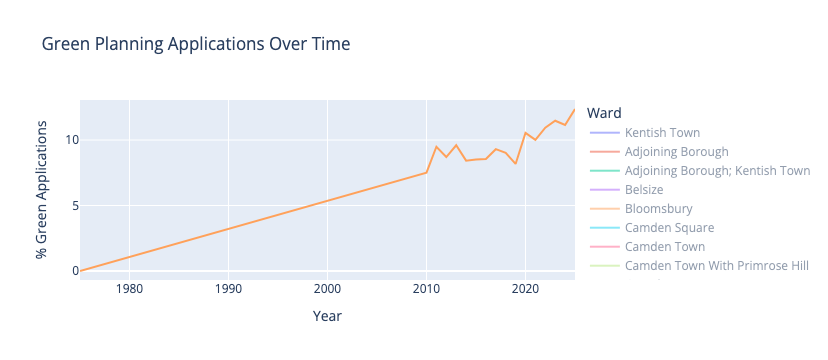

Chart rendered at: 2025-09-28 20:19:14


In [28]:
# --- VISUALISING GREEN PLANNING APPLICATIONS OVER TIME --- I MISS TABLEAU!


# Clean decision_date and extract year
df_merged['decision_date'] = pd.to_datetime(df_merged['decision_date'], dayfirst=True, errors='coerce')
df_merged = df_merged.dropna(subset=['decision_date'])  # drop invalid dates
df_merged['decision_year'] = df_merged['decision_date'].dt.year

# Aggregate % green by year and ward
time_summary = (
    df_merged.groupby(['decision_year', 'ward_final'], dropna=False)
             .agg(total_count=('is_green', 'size'),
                  green_count=('is_green', 'sum'))
             .reset_index()
)
time_summary['pct_green'] = 100 * time_summary['green_count'] / time_summary['total_count']

# Keep only wards that have at least one green application
wards_with_green = time_summary.groupby('ward_final')['green_count'].sum()
wards_with_green = wards_with_green[wards_with_green > 0].index.tolist()
time_summary = time_summary[time_summary['ward_final'].isin(wards_with_green)]

# Compute aggregate (all wards)
agg_summary = (
    df_merged.groupby('decision_year', dropna=False)
             .agg(total_count=('is_green', 'size'),
                  green_count=('is_green', 'sum'))
             .reset_index()
)
agg_summary['pct_green'] = 100 * agg_summary['green_count'] / agg_summary['total_count']
agg_summary['ward_final'] = 'All Wards'

# Combine aggregate + ward-level data
plot_summary = pd.concat([time_summary, agg_summary], ignore_index=True)

# Create interactive line chart
fig = px.line(
    plot_summary,
    x='decision_year',
    y='pct_green',
    color='ward_final',
    labels={'pct_green': '% Green Applications', 'decision_year': 'Year', 'ward_final': 'Ward'},
    hover_data={'green_count': True, 'total_count': True},
    title='Green Planning Applications Over Time'
)

# Customize hover text
for trace in fig.data:
    trace.hovertemplate = (
        "%{fullData.name}<br>" +
        "%{y:.1f}%<br>" +
        "%{customdata[0]}/%{customdata[1]}"
    )

# Set initial visibility
for trace in fig.data:
    if trace.name == 'All Wards':
        trace.visible = True
    else:
        trace.visible = 'legendonly'  # hidden but selectable in legend

# Legend acts as multi-select
fig.update_layout(
    hovermode='x unified',
    legend_title='Ward',
    legend=dict(
        itemclick='toggle',         # click toggles individual traces
        itemdoubleclick='toggleothers'  # double click isolates one trace
    )
)

fig.show()
print(f"Chart rendered at: {time.strftime('%Y-%m-%d %H:%M:%S')}")


/var/folders/k1/lkhx_pfs64v10ky854xhlg0m0000gn/T/ipykernel_28728/3685053737.py:28: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



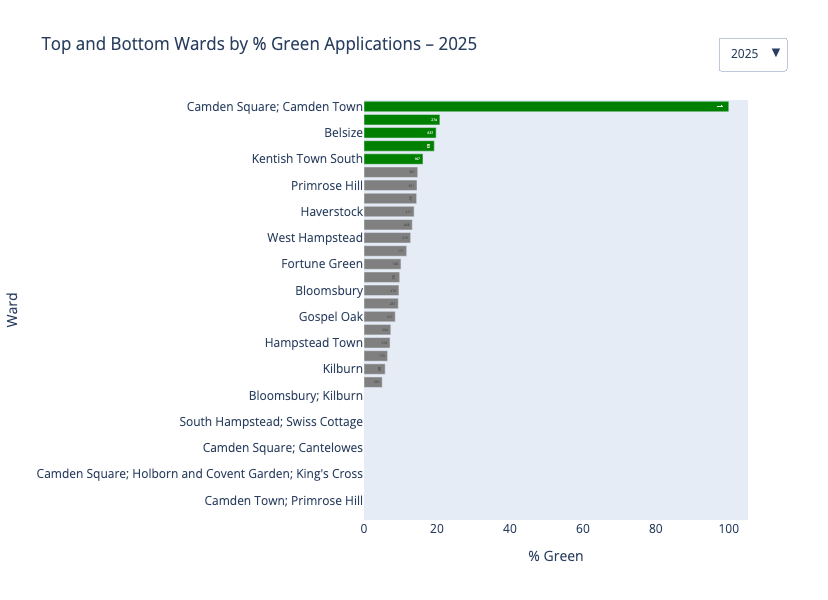

Chart rendered at: 2025-09-28 20:19:25


In [29]:
# --- VISUALISE ALL WARDS YEAR BY YEAR ---
''' This works fine, but apparently Pandas is deprecating 
DataFrameGroupBy.apply operated on the grouping columns.
Would need to amend in future.
'''

# Filter data since 2011
df_filtered = df_merged[pd.to_datetime(df_merged['decision_date'], dayfirst=True).dt.year >= 2011].copy()
df_filtered['decision_year'] = pd.to_datetime(df_filtered['decision_date'], dayfirst=True).dt.year

# Aggregate by year and ward 
ward_year_summary = (
    df_filtered.groupby(['decision_year', 'ward_final'], dropna=False)
               .agg(total_count=('is_green', 'size'),
                    green_count=('is_green', 'sum'))
               .reset_index()
)
ward_year_summary['pct_green'] = 100 * ward_year_summary['green_count'] / ward_year_summary['total_count']

# Assign colors per year
def assign_colors(group):
    group_sorted = group.sort_values('pct_green', ascending=False).copy()
    group_sorted['color'] = 'grey'
    group_sorted.loc[group_sorted.head(5).index, 'color'] = 'green'
    group_sorted.loc[group_sorted.tail(5).index, 'color'] = 'red'
    return group_sorted

ward_year_summary = ward_year_summary.groupby('decision_year', group_keys=False).apply(assign_colors)

# Build figure
years = sorted(ward_year_summary['decision_year'].unique(), reverse=True)
initial_year = years[0]

fig = go.Figure()

# Add traces for each year, initially only show the latest year
for year in years:
    df_year = ward_year_summary[ward_year_summary['decision_year'] == year]
    fig.add_trace(go.Bar(
        x=df_year['pct_green'],
        y=df_year['ward_final'],
        orientation='h',
        text=df_year['total_count'],
        marker_color=df_year['color'],
        name=str(year),
        visible=(year == initial_year),
        hovertemplate='%{y}<br>%{x:.1f}%<br>%{text} applications'
    ))

# Dropdown for years
buttons = []
for i, year in enumerate(years):
    visible = [j == i for j in range(len(years))]
    buttons.append(dict(
        label=str(year),
        method='update',
        args=[{'visible': visible},
              {'title': f'Top and Bottom Wards by % Green Applications – {year}'}]
    ))

fig.update_layout(
    updatemenus=[dict(active=0, buttons=buttons, x=1.1, y=1.15)],
    title=f'Top and Bottom Wards by % Green Applications – {initial_year}',
    xaxis_title='% Green',
    yaxis_title='Ward',
    yaxis=dict(autorange='reversed'),
    height=600
)

fig.show()
print(f"Chart rendered at: {time.strftime('%Y-%m-%d %H:%M:%S')}")


In [30]:
# --- HOW OFTEN ARE DIFFERENT DECISIONS MADE? ---

# Build the table
decision_table = (
    df['decision']
      .value_counts(dropna=False)           # count each unique value (including NaN)
      .rename_axis('Decision')              # name the index
      .reset_index(name='Count')            # convert to DataFrame
)

# Show full table with no column-wrapping
with pd.option_context(
    'display.max_rows', None,      # show all rows
    'display.max_columns', None,   # show all columns
    'display.width', 2000,         # set a very wide display width
    'display.max_colwidth', None   # don’t truncate column contents
):
    print(decision_table)


                                                                              Decision  Count
0                                                                              Granted  41417
1                                               No Objection to Works to Tree(s) in CA  13653
2                                                                   Withdrawn Decision   5854
3                                                                              Refused   3995
4                                                                  Approve Works (TPO)   3611
5                                     Granted Subject to a Section 106 Legal Agreement   3339
6                                                 No Objection to Emergency Works (CA)    843
7                                                                         No objection    542
8                                Refused and Warning of Enforcement Action to be Taken    442
9                                                           

In [ ]:
# --- END NOTE ---

'''So far I've ascertained how many applications have been submitted that have some notion of greenness. 
But an additional end point we'd like is to compare the rate of applications being accepted vs refused
and whether there's any relationship to greenness. 

Required steps:
categorise decisions into "yes", "no", "N/A"
Run analysis

Problem exists in that different types of applications may be more/less likely to be green
And these may also have their own rates of being submitted over time
and of being accepted/rejected.

Unlikely to have enough data if we split by application type,
unless we also remove the ward split.

However, the merit of the project hinges on the semantic vector comparison, so it would make more sense
to spend time refining that before putting in work elsewhere.

'''
